<a href="https://colab.research.google.com/github/CrisGiacomazzi/Sentiment-Analysis-in-Pharmaceutical-Industry/blob/main/Sentiment_Analysis_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
pip -qq install ucimlrepo

In [47]:
pip -qq install vaderSentiment

In [48]:
!pip -qq install --upgrade nltk

In [49]:
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'uci_id': 462, 'name': 'Drug Reviews (Drugs.com)', 'repository_url': 'https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com', 'data_url': 'https://archive.ics.uci.edu/static/public/462/data.csv', 'abstract': 'The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction.', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Text'], 'num_instances': 215063, 'num_features': 6, 'feature_types': ['Integer'], 'demographics': [], 'target_col': None, 'index_col': ['id'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Wed Apr 03 2024', 'dataset_doi': '10.24432/C5SK5S', 'creators': ['Surya Kallumadi', 'Felix Grer'], 'intro_paper': {'ID': 407, 'type': 'NATIVE', 'title': 'Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data 

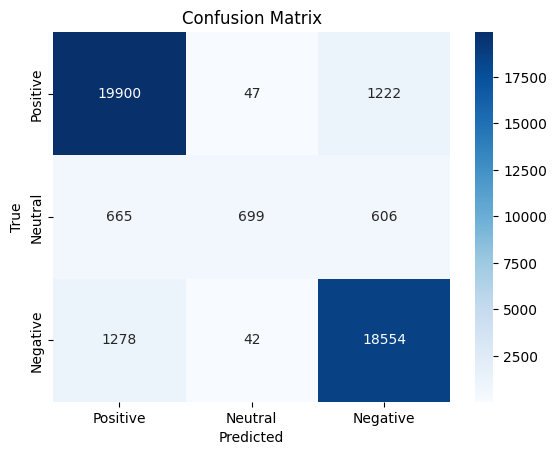

In [50]:
from ucimlrepo import fetch_ucirepo
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords

# Download stopwords if not already available
import nltk
nltk.download('stopwords')

# Tokenization using regex and text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize by words using regex
    words = re.findall(r'\w+', text)

    # Remove stopwords using NLTK
    stop_words = set(stopwords.words('english'))

    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Fetch dataset
drug_reviews_drugs_com = fetch_ucirepo(id=462)

# Data (as pandas DataFrames)
X = drug_reviews_drugs_com.data.features  # Reviews and other features
y = drug_reviews_drugs_com.data.targets   # Target labels (e.g., ratings or other outcomes)

# Metadata and variable information
print(drug_reviews_drugs_com.metadata)
print(drug_reviews_drugs_com.variables)

# Create a DataFrame to work with text data
df = pd.concat([X, y], axis=1)

# Check for the column with text reviews (adjust column name as per the dataset)
print(df.head())  # Inspect the dataset to find the relevant text column
text_column = "review"  # Replace with the actual column name containing the reviews

# Clean the reviews column
df[text_column] = df[text_column].apply(clean_text)

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

# Add sentiment columns
sentiments = {"TextBlob_Sentiment": [], "VADER_Sentiment": []}

for review in df[text_column]:
    # Ensure text is not null
    if pd.notnull(review):
        # TextBlob Sentiment
        blob = TextBlob(review)
        textblob_polarity = blob.sentiment.polarity
        if textblob_polarity > 0:
            textblob_sentiment = "Positive"
        elif textblob_polarity < 0:
            textblob_sentiment = "Negative"
        else:
            textblob_sentiment = "Neutral"
        sentiments["TextBlob_Sentiment"].append(textblob_sentiment)

        # VADER Sentiment
        vader_scores = vader_analyzer.polarity_scores(review)
        vader_compound = vader_scores["compound"]
        if vader_compound > 0.05:
            vader_sentiment = "Positive"
        elif vader_compound < -0.05:
            vader_sentiment = "Negative"
        else:
            vader_sentiment = "Neutral"
        sentiments["VADER_Sentiment"].append(vader_sentiment)
    else:
        sentiments["TextBlob_Sentiment"].append("Neutral")
        sentiments["VADER_Sentiment"].append("Neutral")

# Add sentiment results to the DataFrame
df["TextBlob_Sentiment"] = sentiments["TextBlob_Sentiment"]
df["VADER_Sentiment"] = sentiments["VADER_Sentiment"]

# Prepare features for machine learning model (e.g., TextBlob Sentiment for training a model)
X_text = df['review']  # Text data for classification
y_text = df['VADER_Sentiment']  # Target sentiment labels (VADER as true labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

# Vectorization (convert text into numerical format)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Initialize Logistic Regression
logreg = LogisticRegression()

# Define parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers for optimization
    'max_iter': [100, 200]  # Maximum number of iterations for convergence
}

# Apply GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(logreg, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_vec, y_train)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Make predictions using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate Precision, Recall, and F1-Score
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {fscore:.2f}")

# Display Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=["Positive", "Neutral", "Negative"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Neutral", "Negative"], yticklabels=["Positive", "Neutral", "Negative"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the updated DataFrame to a CSV for further analysis (optional)
df.to_csv("drug_reviews_with_sentiment.csv", index=False)


Top 10 Drugs with the Highest Negative Sentiments:
VADER_Sentiment                     Negative  Neutral  Positive
drugName                                                       
Levonorgestrel                          2747      198      1985
Etonogestrel                            1877      131      2413
Ethinyl estradiol / norethindrone       1693      109      1951
Ethinyl estradiol / norgestimate        1320       93      1377
Nexplanon                               1299       79      1514
Sertraline                              1124       71       673
Ethinyl estradiol / levonorgestrel      1117       92      1294
Escitalopram                             953       56       738
Miconazole                               887       37       420
Mirena                                   808       62       803


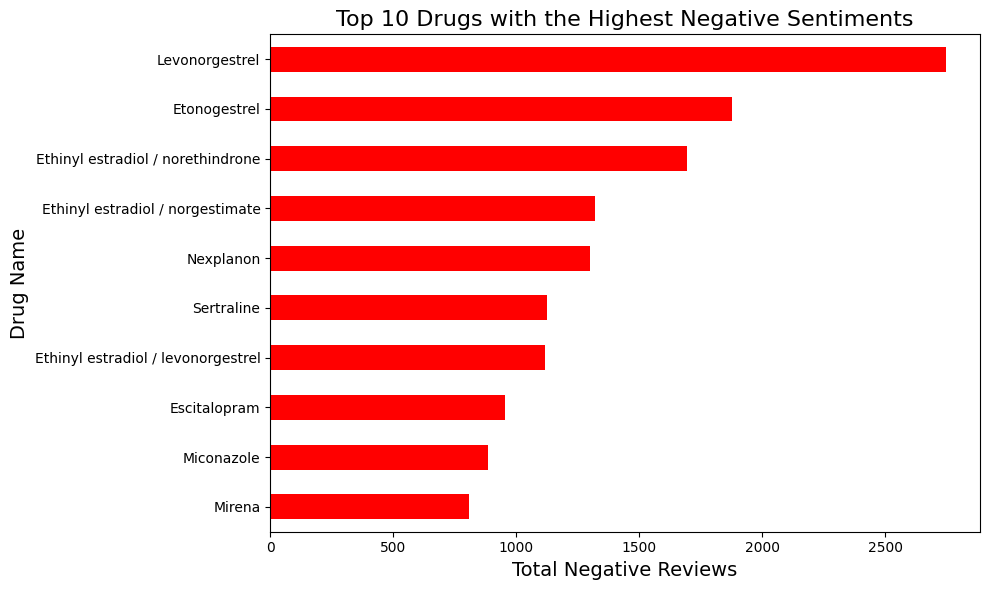

In [51]:
# Group by drugName and Sentiment
rug_column = "drugName" # Assuming 'drugName' is the correct column name for drug names
sentiment_counts = df.groupby([drug_column, "VADER_Sentiment"]).size().unstack(fill_value=0)

# Sort the data by the "Negative" sentiment count in descending order
top_negative = sentiment_counts.sort_values(by="Negative", ascending=False).head(10)

# Display the result
print("Top 10 Drugs with the Highest Negative Sentiments:")
print(top_negative)

# Plotting the top 10 drugs with the highest negative sentiment
plt.figure(figsize=(10, 6))
top_negative["Negative"].plot(kind="barh", color="red")
plt.title("Top 10 Drugs with the Highest Negative Sentiments", fontsize=16)
plt.xlabel("Total Negative Reviews", fontsize=14)
plt.ylabel("Drug Name", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

# Show the plot
plt.show()


Evaluating the model